# Vehicle Price Prediction

Introduction

The automobile industry has witnessed tremendous growth over the years, and with the increasing demand for both new and used vehicles, determining a car’s market value has become a vital aspect of buying and selling decisions. Vehicle prices depend on multiple factors such as manufacturing year, mileage, fuel type, transmission, brand, and more.

This project aims to build a machine learning model that accurately predicts the price of a vehicle using its features. By analyzing a structured dataset and applying robust preprocessing and modeling techniques, the goal is to assist consumers and businesses in estimating fair vehicle prices and making informed financial choices.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score


In [28]:
# Load the dataset
df = pd.read_csv('dataset.csv')


In [68]:
df.head()

,make,model,year,price,engine,cylinders,fuel,mileage,transmission,trim,body,doors,exterior_color,interior_color,drivetrain
0,Jeep,Wagoneer,2024,74600.0,24V GDI DOHC Twin Turbo,6.0,Gasoline,10.0,8-Speed Automatic,Series II,SUV,4.0,White,Global Black,Four-wheel Drive
1,Jeep,Grand Cherokee,2024,50170.0,OHV,6.0,Gasoline,1.0,8-Speed Automatic,Laredo,SUV,4.0,Metallic,Global Black,Four-wheel Drive
2,GMC,Yukon XL,2024,96410.0,"6.2L V-8 gasoline direct injection, variable v...",8.0,Gasoline,0.0,Automatic,Denali,SUV,4.0,Summit White,Teak/Light Shale,Four-wheel Drive
3,Dodge,Durango,2023,46835.0,16V MPFI OHV,8.0,Gasoline,32.0,8-Speed Automatic,Pursuit,SUV,4.0,White Knuckle Clearcoat,Black,All-wheel Drive
4,RAM,3500,2024,81663.0,24V DDI OHV Turbo Diesel,6.0,Diesel,10.0,6-Speed Automatic,Laramie,Pickup Truck,4.0,Silver,Black,Four-wheel Drive


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 978 entries, 0 to 1001
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   make            978 non-null    object 
 1   model           978 non-null    object 
 2   year            978 non-null    int64  
 3   price           978 non-null    float64
 4   engine          978 non-null    object 
 5   cylinders       978 non-null    float64
 6   fuel            978 non-null    object 
 7   mileage         978 non-null    float64
 8   transmission    978 non-null    object 
 9   trim            978 non-null    object 
 10  body            978 non-null    object 
 11  doors           978 non-null    float64
 12  exterior_color  978 non-null    object 
 13  interior_color  978 non-null    object 
 14  drivetrain      978 non-null    object 
dtypes: float64(4), int64(1), object(10)
memory usage: 122.2+ KB


In [76]:
df.describe()

,year,price,cylinders,mileage,doors
count,978.000000,978.000000,978.000000,978.000000,978.000000
mean,2023.916155,50254.317996,4.874233,65.339468,3.944785
std,0.298623,18640.823226,1.352631,502.253182,0.269611
min,2023.000000,17994.000000,0.000000,0.000000,2.000000
25%,2024.000000,36633.500000,4.000000,4.000000,4.000000
50%,2024.000000,47170.000000,4.000000,8.000000,4.000000
75%,2024.000000,58924.750000,6.000000,12.000000,4.000000
max,2025.000000,195895.000000,8.000000,9711.000000,5.000000


In [78]:
df.columns

Index(['make', 'model', 'year', 'price', 'engine', 'cylinders', 'fuel',
       'mileage', 'transmission', 'trim', 'body', 'doors', 'exterior_color',
       'interior_color', 'drivetrain'],
      dtype='object')

In [30]:
# Droping rows where price is missing or invalid
df.dropna(subset=['price'], inplace=True)
df = df[df['price'] > 100]

In [32]:
# Droping unnecessary columns
df.drop(['name', 'description'], axis=1, inplace=True, errors='ignore')


In [34]:
# Filling missing values with reasonable defaults
df.fillna({
    'cylinders': df['cylinders'].mode()[0],
    'fuel': df['fuel'].mode()[0],
    'mileage': df['mileage'].median(),
    'transmission': df['transmission'].mode()[0],
    'trim': 'Unknown',
    'body': df['body'].mode()[0],
    'doors': df['doors'].mode()[0],
    'exterior_color': 'Unknown',
    'interior_color': 'Unknown',
    'drivetrain': df['drivetrain'].mode()[0],
    'engine': 'Unknown'
}, inplace=True)

In [36]:
# Spliting features and target
X = df.drop('price', axis=1)
y = df['price']


In [38]:
# Separating categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()


In [107]:
# Preprocessing pipeline with future-proofing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough',
    force_int_remainder_cols=False
)


In [109]:
# Combining preprocessor with model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [111]:
# Spliting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [113]:
# GridSearchCV for hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['make',
                                                                          'model',
                                                                          'engine',
                                                                          'fuel',
                                                                          'transmission',
                                                                          'trim',
                                                                          'body',
                                                                          'exterior_color',
                                                                          'interior_color',
                                                                          'drivetrain'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [None, 10, 20],
                         'regressor__n_estimators': [100, 200]},
             scoring='neg_mean_absolute_error')

In [47]:
# Best model
model = grid_search.best_estimator_
y_pred = model.predict(X_test)


In [117]:
#Evaluation
from sklearn.metrics import mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Absolute Error (MAE): 4132.41
Root Mean Squared Error (RMSE): 7516.47
R² Score: 0.84


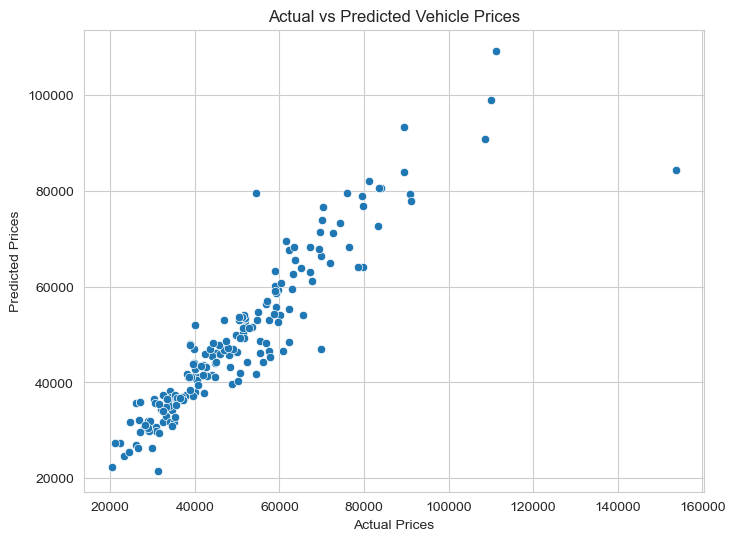

In [119]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Vehicle Prices")
plt.grid(True)
plt.show()


In [49]:
# Feature importance
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importances = model.named_steps['regressor'].feature_importances_

In [50]:
# Plot feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

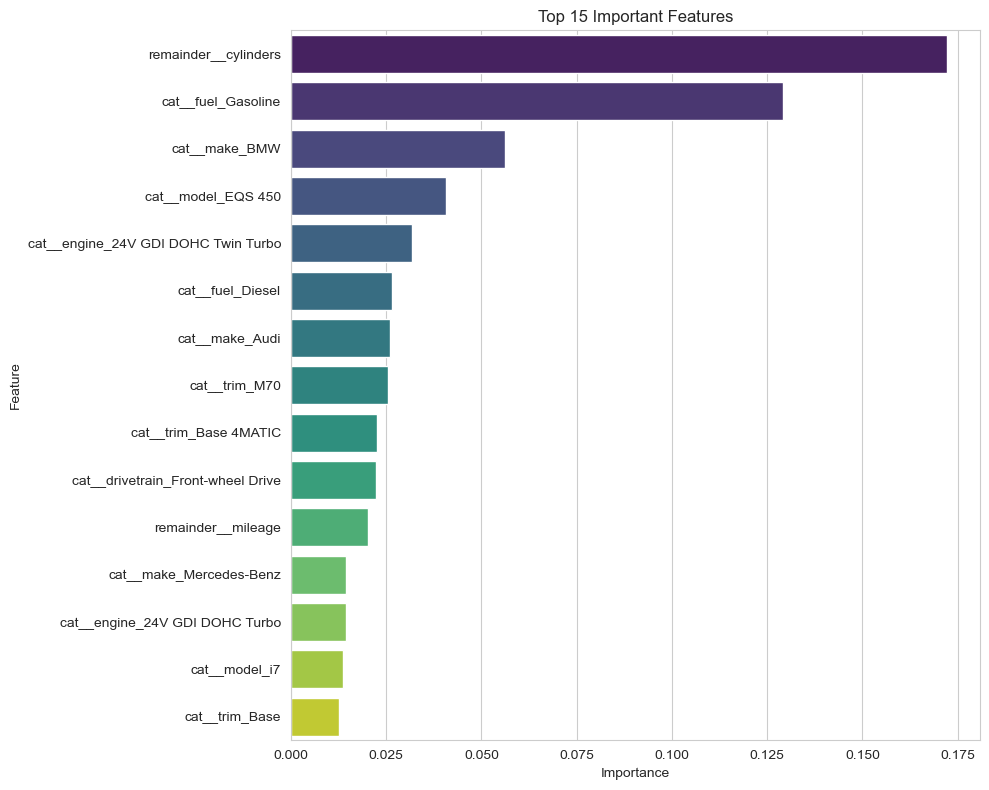

In [88]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature',hue='Feature', data=importance_df.head(15),palette='viridis' )
plt.title("Top 15 Important Features")
plt.tight_layout()
plt.show()

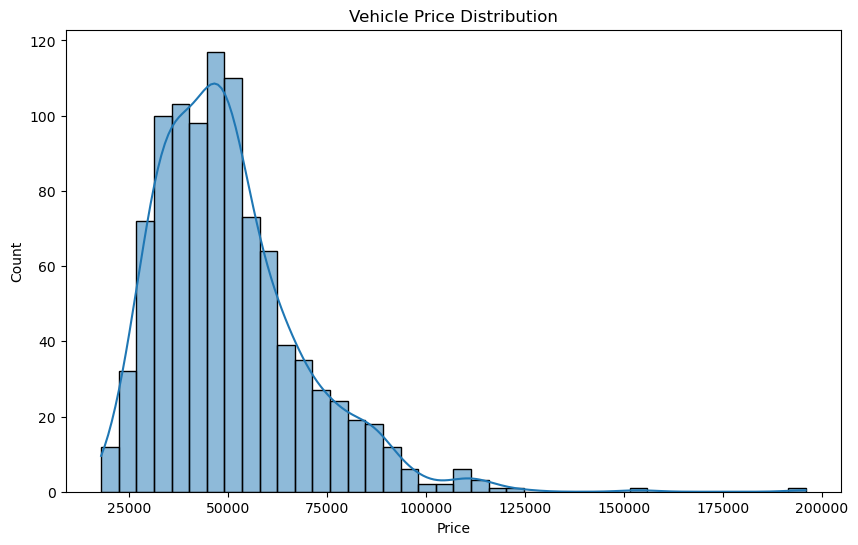

In [52]:
# Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=40, kde=True)
plt.title("Vehicle Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

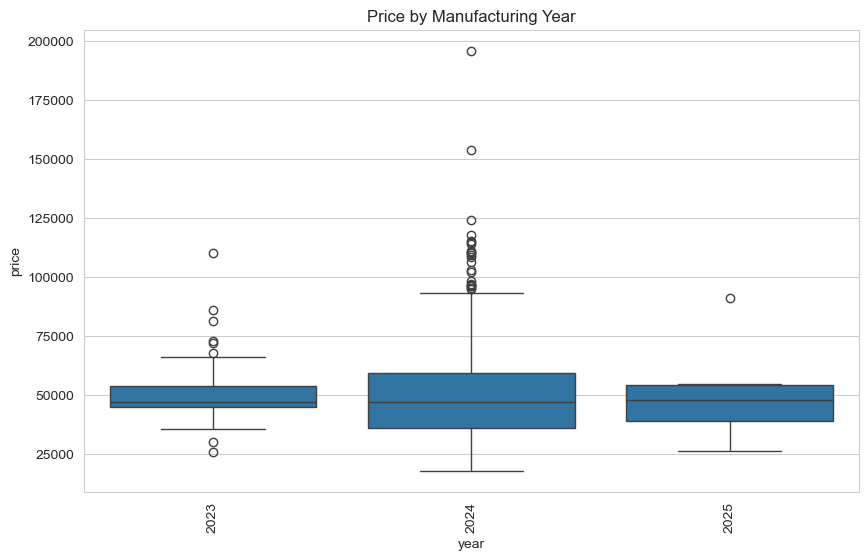

In [90]:
# Price vs Year
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='year', y='price')
plt.xticks(rotation=90)
plt.title("Price by Manufacturing Year")
plt.show()

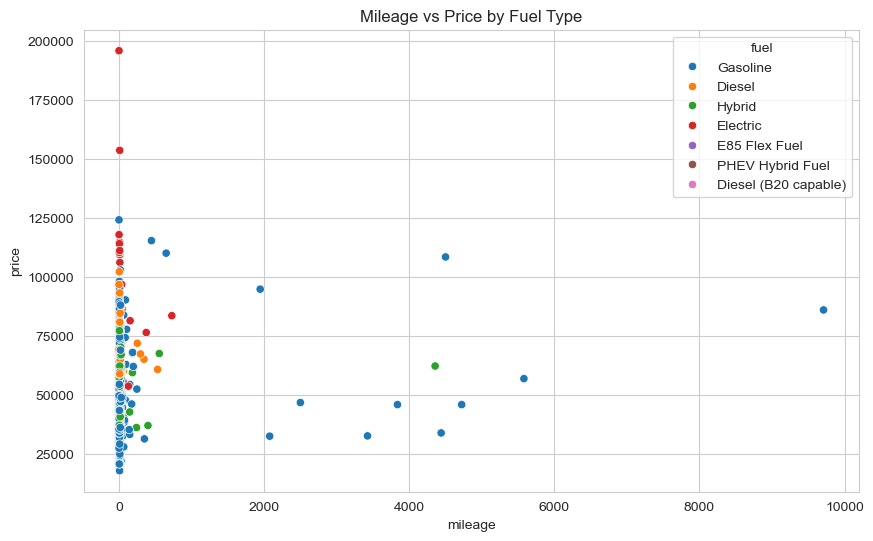

In [92]:
# Mileage vs Price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='mileage', y='price', hue='fuel')
plt.title("Mileage vs Price by Fuel Type")
plt.show()

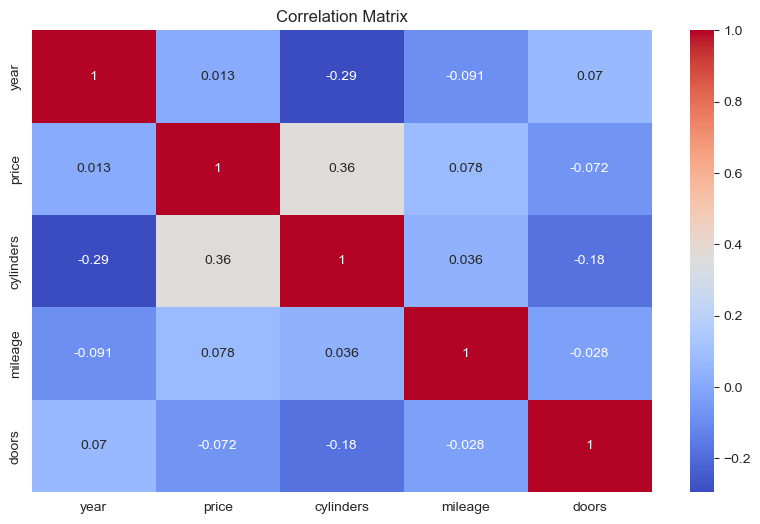

In [93]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [95]:
# Save predictions
predicted_df = X_test.copy()
predicted_df['actual_price'] = y_test
predicted_df['predicted_price'] = y_pred
predicted_df.to_csv('predicted_output.csv', index=False)
print("\nPredictions saved to 'predicted_output.csv'")



Predictions saved to 'predicted_output.csv'




## Conclusion

The vehicle price prediction model developed in this project demonstrated reliable performance using a Random Forest Regressor, enhanced with data preprocessing pipelines and hyperparameter tuning. By transforming categorical features with OneHotEncoding and optimizing model parameters through GridSearchCV, the model achieved strong accuracy metrics.

Furthermore, exploratory data analysis and feature importance visualization offered valuable insights into the key factors influencing vehicle prices. The resulting predictions can serve as a decision-making tool for buyers, sellers, and dealerships to assess vehicle value in the current market landscape.